Through this notebook we try to see if a stacked LSTM can learn to follow a target series from an inverse time lagged input series. The two series here are the percent change in Real GDP and the unemployment rate as the target series.

In [1]:
#Loading the required packages
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from pandas import concat
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
#Loading the Unemploymet Time Series
unemp=pd.read_csv("UNRATENSA.csv",header=0,sep=",")

#Converting to datetime
unemp['DATE']=pd.to_datetime(unemp['DATE'])

print (unemp.head())

        DATE  UNRATENSA
0 1948-01-01        4.0
1 1948-02-01        4.7
2 1948-03-01        4.5
3 1948-04-01        4.0
4 1948-05-01        3.4


In [3]:
#Loading the RGDP Time series
gdp=pd.read_csv("RGDP_Final.csv",header=0,sep=",")
gdp['DATE'] = pd.to_datetime(gdp['DATE'])

#converting the data to YYYY-MM format
gdp['DATE']=gdp.DATE.map(lambda x: x.strftime('%Y-%m'))

print(gdp.head())

      DATE  UNRATENSA
0  1947-04       -0.4
1  1947-07       -0.4
2  1947-10        6.4
3  1948-01        6.0
4  1948-04        6.7


In [4]:
#Aggregating Unemployment series to quarterly using mean of series
unemp_qtr=unemp.set_index('DATE').groupby(pd.TimeGrouper('3M')).mean()
unemp_qtr.reset_index(inplace=True)

#converting the data to YYYY-MM format
unemp_qtr['DATE']=unemp_qtr.DATE.map(lambda x: x.strftime('%Y-%m'))

print (unemp_qtr.head())

      DATE  UNRATENSA
0  1948-01   4.000000
1  1948-04   4.400000
2  1948-07   3.733333
3  1948-10   3.300000
4  1949-01   3.966667


In [5]:
#Reconverting dates as Columns
unemp_qtr['DATE']=pd.to_datetime(unemp_qtr['DATE'])
gdp['DATE'] = pd.to_datetime(gdp['DATE'])

In [6]:
#Renaming GDP Column names
gdp=gdp.drop(gdp.index[0])
gdp.columns=['DATE','GDP']

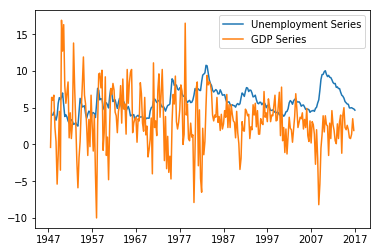

In [7]:
#Plotting the original series
plt.figure()
plt.plot(unemp_qtr["DATE"],unemp_qtr["UNRATENSA"],label='Unemployment Series')
plt.plot(gdp["DATE"],gdp["GDP"],label='GDP Series')
plt.legend(loc='upper right')
plt.show()

Extremely choppy series, we really cannot infer much from the 2 series , let us decompose the 2 series

In [8]:
#We use Seasonal decompose [STL in R]
unemp_qtr.reset_index(inplace=True)
unemp_qtr= unemp_qtr.set_index('DATE')
unemp_qtr = unemp_qtr.drop('index', 1)
ts=sm.tsa.seasonal_decompose(unemp_qtr)

ts.plot()
#let's remove seasonality and remainder

unemp_trend=ts.trend
unemp_trend.reset_index(inplace=True)

In [9]:
#Same for the GDP series
gdp.reset_index(inplace=True)
gdp=gdp.set_index('DATE')
gdp = gdp.drop('index', 1)
ts1=sm.tsa.seasonal_decompose(gdp)

ts1.plot()

gdp_trend=ts1.trend
gdp_trend.reset_index(inplace=True)

Let us now plot the oscillations of the series

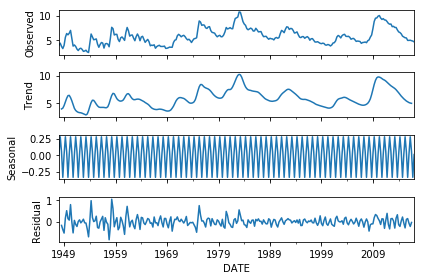

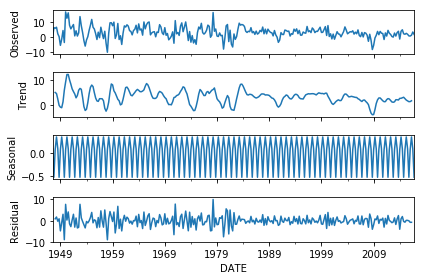

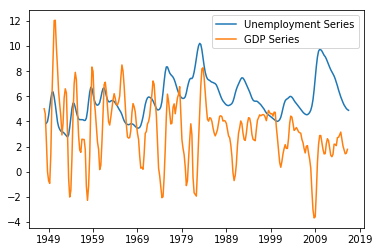

In [10]:
#Plotting the trend series
plt.figure()
plt.plot(unemp_trend["DATE"],unemp_trend["UNRATENSA"],label='Unemployment Series')
plt.plot(gdp_trend["DATE"],gdp_trend["GDP"],label='GDP Series')
plt.legend(loc='upper right')
plt.show()

We can infer that the Time lagged peaks of GDP are inversely proportional to the Unemployment series consistently

In [11]:
#Let's model the trend and see if the LSTM Model learns

#Dropping NA columns
gdp_trend=gdp_trend.drop(gdp_trend.index[[0,1,276,277]])
unemp_trend=unemp_trend.drop(unemp_trend.index[[0,1,275,276]])

#Merging the 2 series, we use inner join to ensure the GDP series which is a year longer is mapped correctly
combined=gdp_trend.merge(unemp_trend,left_on='DATE', right_on='DATE', how='inner')

#Converting the 2 series to list for input to our create_dataset() function
gdp_list=combined.GDP.values.T.tolist()
unemp_list=combined.UNRATENSA.values.T.tolist()

We want to model the current unemployment rate value based on the previously seen values of change in GDP, we will thus create a look back input series, we look back 3 time steps to predict the current value of unemployment

In [12]:
#create look back input output series
def create_dataset(X,Y, look_back=3):
	dataX, dataY = [], []
	for i in range(len(X)-look_back-1):
		a = X[i:(i+look_back)]
		dataX.append(a)
		dataY.append(Y[i + look_back])
	return np.array(dataX), np.array(dataY)


X,y=create_dataset(gdp_list,unemp_list)

print (X[0:6])

print (X.shape)

print (y[0:6])

print (y.shape)

[[  2.42500000e+00   8.32667268e-17  -7.25000000e-01]
 [  8.32667268e-17  -7.25000000e-01  -9.37500000e-01]
 [ -7.25000000e-01  -9.37500000e-01   1.36250000e+00]
 [ -9.37500000e-01   1.36250000e+00   5.90000000e+00]
 [  1.36250000e+00   5.90000000e+00   9.12500000e+00]
 [  5.90000000e+00   9.12500000e+00   1.20375000e+01]]
(268, 3)
[ 5.15833333  5.81666667  6.3         6.35416667  5.94583333  5.35833333]
(268,)


In [13]:
#creating train and test sets

X_train=X[0:206,:]
y_train=y[0:206]

X_test=X[206:,:]

#we need y_test with the dates for comparison purposes
y_test=combined[206:]

Next we'll normalize our data between [0,1] for input to our neural networks. We will min-max scaling to normalize our data

In [14]:
max_=X_train.max()

min_=X_train.min()

X_train=(X_train-min_)/(max_-min_)

#normalizing y
max_y=y_train.max()

min_y=y_train.min()

y_train=(y_train-min_y)/(max_y-min_y)

We do not normalize our test set, as we expect them to be unseen, we will use the max and min values obtained from the train set to normalize our test set itself

In [15]:
#Train input

X, y = X_train[:, 0:], y_train

We'll save the weights from best iterations, these weights are avialble in the 'weights' folder. We will create a callback function to save our weights

In [17]:
#We monitor the loss save iterations with minimum loss
file="weights.best.hdf5"
checkpoint = ModelCheckpoint(file, monitor='loss', verbose=1, save_best_only=True, mode='min')
early_stop =  EarlyStopping(monitor='loss', min_delta=0.001, patience=200, verbose=1, mode='min')
callbacks = [checkpoint,early_stop]

Next we create a LSTM model using keras

First we reshape data to have the following format [Number of row, number of time steps,1]

In [18]:
#We reshape data 
X = X.reshape(X.shape[0],X.shape[1],1)

Next we create the LSTM Model

First LSTM Layer with 18 hidden neurons initialized using 'glorot', recurrent layers are initialized using 'orthogonal', we return the learned sequences to higher layers, the input to the layer is [batch size=1,time steps=3,1], we make this layer stateful to ensure we retain the information our layer learns

Secondly we use a dropout layer to prevent our model from overfitting on the input series by randomly dropping neurons from the previous layers

Second LSTM has a similar structure with 9 neurons and without the return sequence, as we do not feed forward the information from this layer

Lastly we use a dense layer to flatten our previous layer and output our results 

We run this for 800 epochs with an ADAM Optimizer

In [19]:
model = Sequential()

model.add(LSTM(18,return_sequences=True,kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', batch_input_shape=(1,X.shape[1],1), stateful=True))
model.add(Dropout(0.3))
model.add(LSTM(9, batch_input_shape=(1,X.shape[1],1), kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',stateful=True))
model.add(Dropout(0.3))
model.add((Dense(1)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, y, epochs=800, batch_size=1,callbacks=callbacks,verbose=0, shuffle=False)


Epoch 00000: loss improved from inf to 0.05820, saving model to weights.best.hdf5
Epoch 00001: loss improved from 0.05820 to 0.04238, saving model to weights.best.hdf5
Epoch 00002: loss improved from 0.04238 to 0.03872, saving model to weights.best.hdf5
Epoch 00003: loss improved from 0.03872 to 0.03846, saving model to weights.best.hdf5
Epoch 00004: loss improved from 0.03846 to 0.03797, saving model to weights.best.hdf5
Epoch 00005: loss improved from 0.03797 to 0.03636, saving model to weights.best.hdf5
Epoch 00006: loss improved from 0.03636 to 0.03616, saving model to weights.best.hdf5
Epoch 00007: loss did not improve
Epoch 00008: loss did not improve
Epoch 00009: loss did not improve
Epoch 00010: loss did not improve
Epoch 00011: loss improved from 0.03616 to 0.03529, saving model to weights.best.hdf5
Epoch 00012: loss improved from 0.03529 to 0.03497, saving model to weights.best.hdf5
Epoch 00013: loss improved from 0.03497 to 0.03374, saving model to weights.best.hdf5
Epoch 00

Epoch 00197: loss did not improve
Epoch 00198: loss did not improve
Epoch 00199: loss did not improve
Epoch 00200: loss did not improve
Epoch 00201: loss did not improve
Epoch 00202: loss did not improve
Epoch 00203: loss did not improve
Epoch 00204: loss did not improve
Epoch 00205: loss did not improve
Epoch 00206: loss did not improve
Epoch 00207: loss did not improve
Epoch 00208: loss did not improve
Epoch 00209: loss did not improve
Epoch 00210: loss did not improve
Epoch 00211: loss did not improve
Epoch 00212: loss did not improve
Epoch 00213: loss did not improve
Epoch 00214: loss did not improve
Epoch 00215: loss did not improve
Epoch 00216: loss did not improve
Epoch 00217: loss did not improve
Epoch 00218: loss did not improve
Epoch 00219: loss did not improve
Epoch 00220: loss did not improve
Epoch 00221: loss did not improve
Epoch 00222: loss did not improve
Epoch 00223: loss did not improve
Epoch 00224: loss did not improve
Epoch 00225: loss did not improve
Epoch 00226: l

Epoch 00422: loss did not improve
Epoch 00423: loss did not improve
Epoch 00424: loss did not improve
Epoch 00425: loss did not improve
Epoch 00426: loss did not improve
Epoch 00427: loss did not improve
Epoch 00428: loss did not improve
Epoch 00429: loss did not improve
Epoch 00430: loss did not improve
Epoch 00431: loss did not improve
Epoch 00432: loss did not improve
Epoch 00433: loss did not improve
Epoch 00434: loss did not improve
Epoch 00435: loss did not improve
Epoch 00436: loss did not improve
Epoch 00437: loss did not improve
Epoch 00438: loss did not improve
Epoch 00439: loss did not improve
Epoch 00440: loss did not improve
Epoch 00441: loss did not improve
Epoch 00442: loss did not improve
Epoch 00443: loss did not improve
Epoch 00444: loss did not improve
Epoch 00445: loss did not improve
Epoch 00446: loss improved from 0.00582 to 0.00556, saving model to weights.best.hdf5
Epoch 00447: loss did not improve
Epoch 00448: loss did not improve
Epoch 00449: loss did not impr

Epoch 00659: loss did not improve
Epoch 00659: early stopping


In [21]:
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 3, 18)                1440      
_________________________________________________________________
dropout_1 (Dropout)          (1, 3, 18)                0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 9)                    1008      
_________________________________________________________________
dropout_2 (Dropout)          (1, 9)                    0         
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    10        
Total params: 2,458.0
Trainable params: 2,458.0
Non-trainable params: 0.0
_________________________________________________________________
None


Next we normalize our test set

In [22]:
X_test=(X_test-min_)/(max_-min_)

Next we make predictions, one sample at a time and rescale our prediction and add it to our list of predictions

In [23]:
#list for predictions
predictions = list()

#making prediction one time step at a time
for i in range(len(X_test)):
    X= X_test[i,:]
    X = X.reshape(1,3,1)
    y = model.predict(X, 1)
    
    #rescaling our output and adding it to the list
    y=y*(max_y-min_y)+min_y
    predictions.append(y)

print (len(predictions))

62


Next we will append to '0' the start of our predictions to, since we miss out on the first few predictions due to the look back format

In [24]:
for i in range (4):
    predictions.insert(i,0)
    
print(len(predictions),len(y_test))

66 66


Let us compare how our model performs

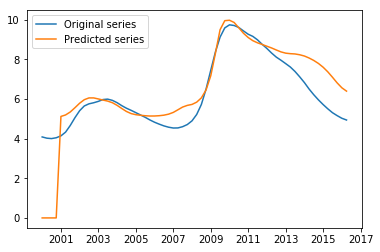

In [25]:
plt.figure()
plt.plot(y_test["DATE"],y_test["UNRATENSA"],label='Original series')
plt.plot(y_test["DATE"],predictions,label='Predicted series')
plt.legend(loc='upper left')
plt.show()

Not at all bad, our model does an excellent job of keeping up with target series

Let's save our model, the model is availble in the 'Model' folder 

In [26]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)